In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm

In [2]:
train_data = pd.read_csv("./dataset/train_data.csv")
test_data=pd.read_csv("./dataset/test_data.csv")


In [3]:
# 마력 컬럼 추가
train_data.loc[train_data[train_data.type == 1].index, "hp"] = 20
train_data.loc[train_data[train_data.type == 2].index, "hp"] = 10
train_data.loc[train_data[train_data.type == 3].index, "hp"] = 50
train_data.hp.fillna(30, inplace=True)

test_data.loc[test_data[test_data.type == 1].index, "hp"] = 20
test_data.loc[test_data[test_data.type == 2].index, "hp"] = 10
test_data.loc[test_data[test_data.type == 3].index, "hp"] = 50
test_data.hp.fillna(30, inplace=True)

In [4]:
new_column = ['out_pressure', 'air_inflow', 'air_end_temp', 'motor_current',
       'motor_rpm', 'motor_temp', 'motor_vibe', 'type', 'hp']

train_data = train_data[new_column]
test_data = test_data[new_column]

In [5]:
# motor_vibe 이상치 제거
outlier_idx = train_data[train_data.motor_vibe > 6].index

train_data = train_data.drop(index=outlier_idx)
train_data.reset_index(drop=True, inplace=True)

In [12]:
train_set = dict()
test_set = dict()
for hptype in [10, 20, 30, 50]:
    train_set[f'{hptype}HP'] = train_data[train_data.hp == hptype]
    test_set[f'{hptype}HP'] = test_data[test_data.hp == hptype]


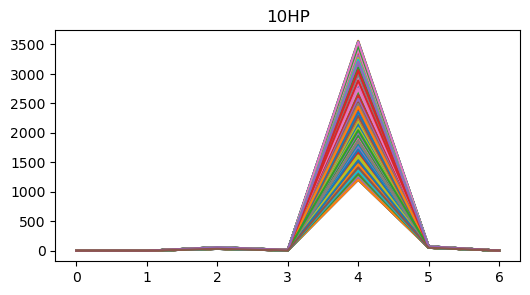

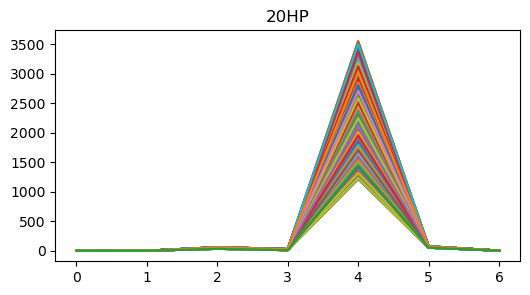

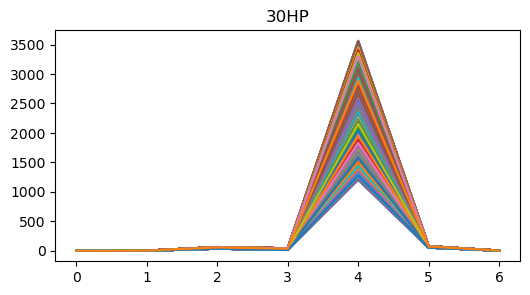

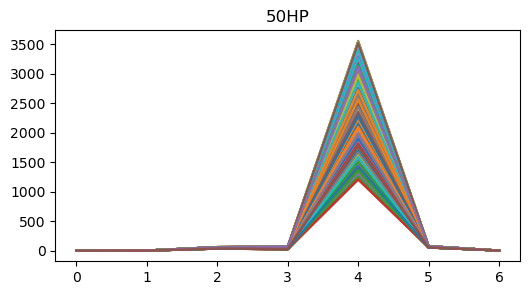

In [54]:
def plot_graph(df, title):
    x = np.arange(len(df.columns))
    plt.figure(figsize=(6,3))
    for i in range(len(df)):
        plt.plot(x, df.iloc[i,:])
    plt.title(f"{title}")
    plt.show()

for key, val_df in train_set.items():
    plot_graph(val_df.iloc[:,:-2], f'{key}')

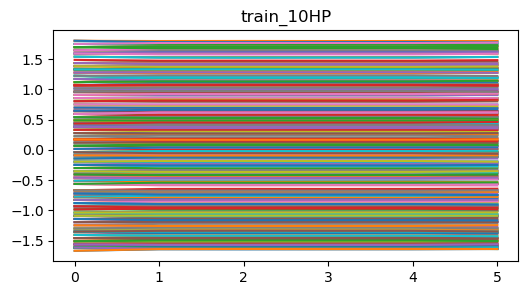

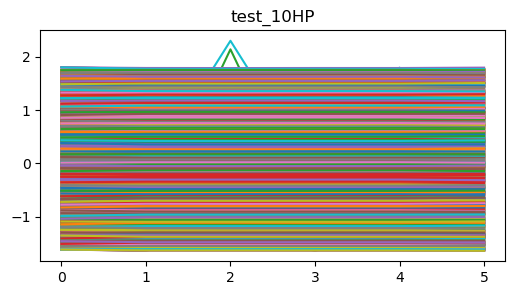

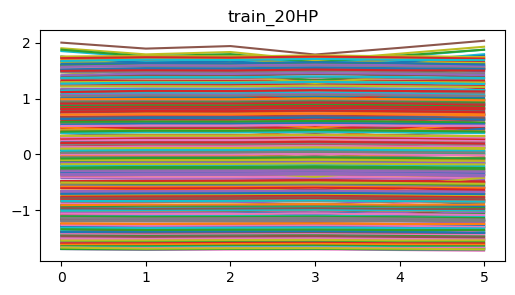

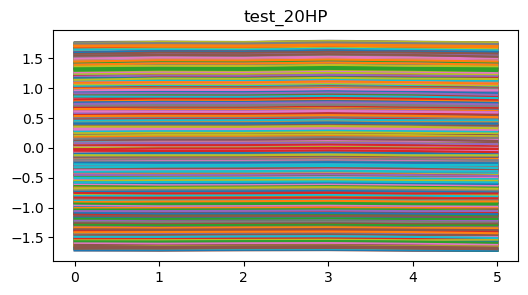

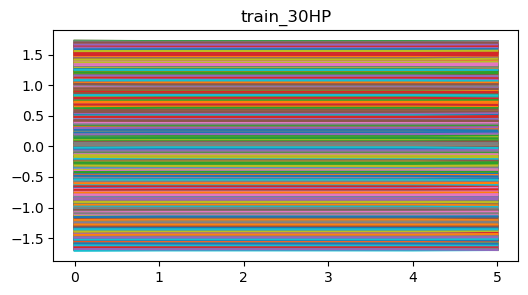

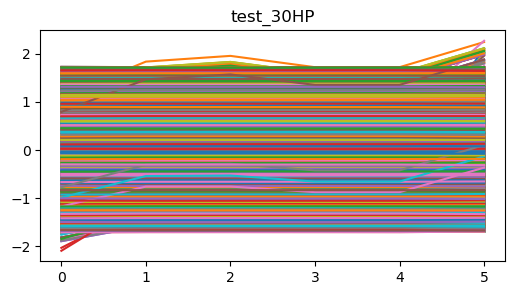

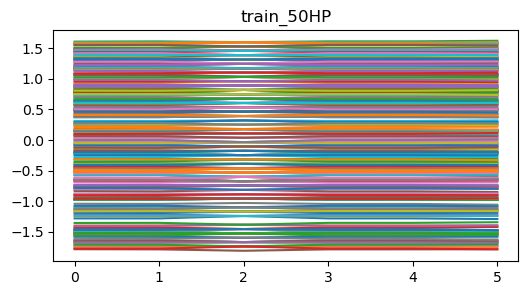

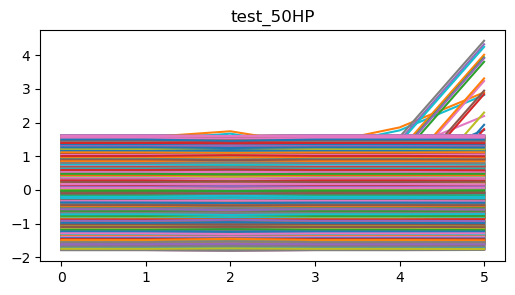

In [58]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def scaling(train, test, scaler):
    scaled_train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
    scaled_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
    return scaled_train, scaled_test


scaled_train = dict()
scaled_test = dict()
for hp in ["10HP", "20HP", "30HP", "50HP"]:
    scaled_train[hp], scaled_test[hp] = scaling(train_set[hp].iloc[:,1:-2], test_set[hp].iloc[:,1:-2],
                                                StandardScaler())
    plot_graph(scaled_train[hp], f'train_{hp}')
    plot_graph(scaled_test[hp], f'test_{hp}')


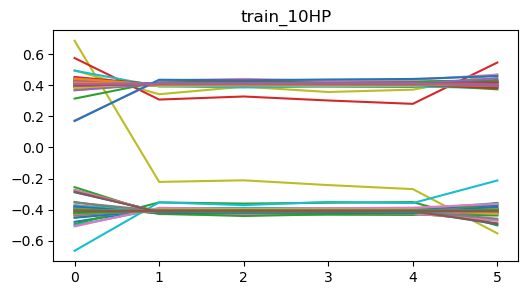

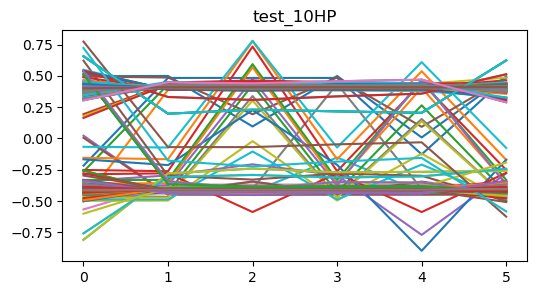

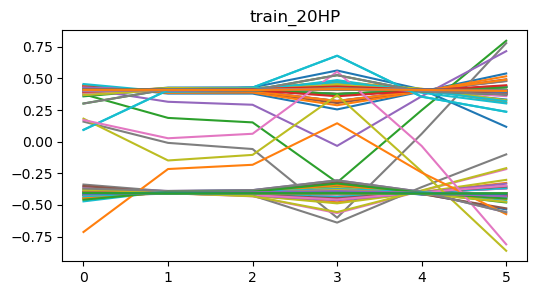

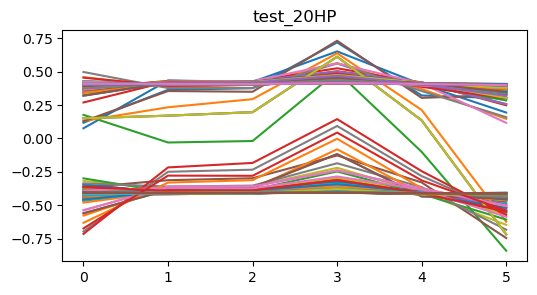

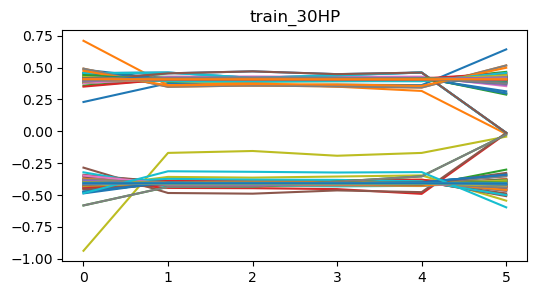

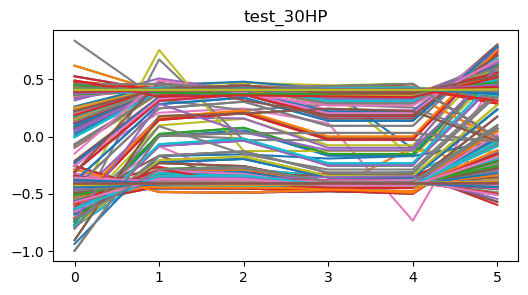

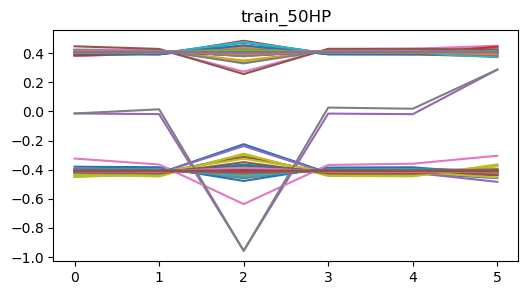

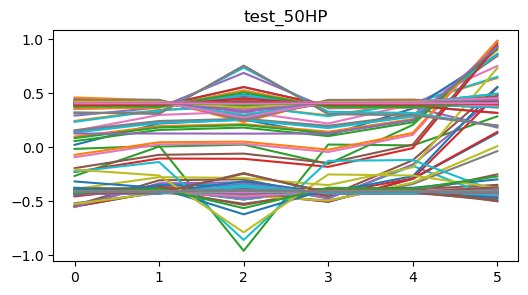

In [60]:
from sklearn.preprocessing import Normalizer

def normalizing(train, test):
    norm = Normalizer()
    normed_train = pd.DataFrame(norm.fit_transform(train), index=train.index, columns=train.columns)
    normed_test = pd.DataFrame(norm.transform(test), index=test.index, columns=test.columns)
    return normed_train, normed_test

norm_train = dict()
norm_test = dict()
for hp in ["10HP", "20HP", "30HP", "50HP"]:
    norm_train[hp], norm_test[hp] = normalizing(scaled_train[hp], scaled_test[hp])
    plot_graph(norm_train[hp], f'train_{hp}')
    plot_graph(norm_test[hp], f'test_{hp}')

### 상관계수


In [42]:
norm_train["30HP"]

,air_end_temp,motor_current,motor_rpm
0,-0.577332,-0.577475,-0.577244
1,0.577557,0.577169,0.577325
2,-0.577437,-0.577017,-0.577596
3,0.578130,0.577126,0.576794
4,-0.577572,-0.577393,-0.577085
...,...,...,...
2442,0.576032,0.578556,0.577460
2443,-0.577248,-0.577297,-0.577505
2444,-0.577351,-0.577303,-0.577397
2445,-0.577325,-0.577459,-0.577267


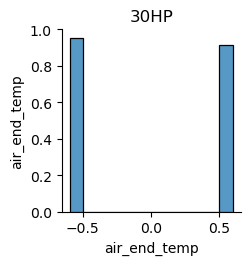

In [41]:
# train 전체
def pair(df, title):
    sns.pairplot(df.iloc[:,:-2])
    plt.title(title)
    plt.show()
    
    
def hmap(df, title):
    sns.heatmap(df.iloc[:,:-2].corr(), annot=True, fmt='.2g', cbar=False)
    plt.title(f"{title}")
    plt.show()


pair(norm_train["30HP"], '30HP')


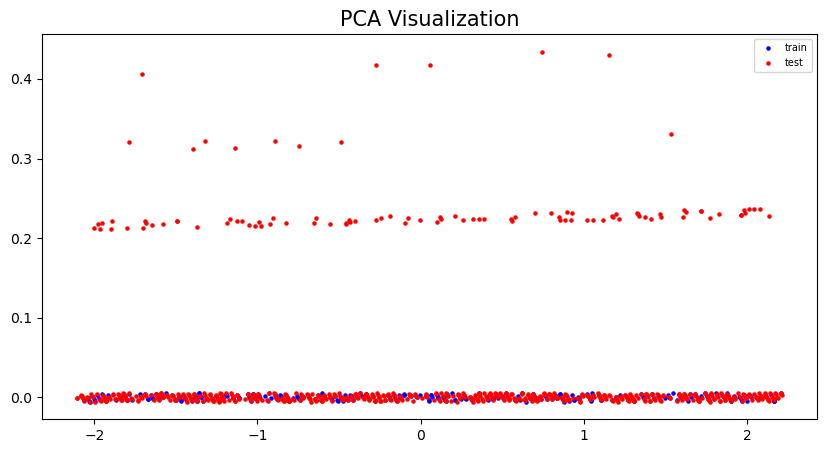

In [5]:
case = 6

temp_train = scaled_train[scaled_train.type == case]
temp_test = scaled_test[scaled_test.type == case]

# temp_train = train_data[train_data.type == case]
# temp_test = test_data[test_data.type == case]


from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1234)
pca_train = pca.fit_transform(temp_train)
pca_test = pca.transform(temp_test)

pca_train = pd.DataFrame(pca_train, index=temp_train.index, columns=['x','y'])
pca_test = pd.DataFrame(pca_test, index=temp_test.index, columns=['x','y'])

# 2차원 시각화
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(pca_train['x'], pca_train['y'], s=5, color='b', label='train')
ax.scatter(pca_test['x'], pca_test['y'], s=5, color='r', label='test')
plt.title("PCA Visualization", fontsize=15)
plt.legend(fontsize=7)
plt.show()

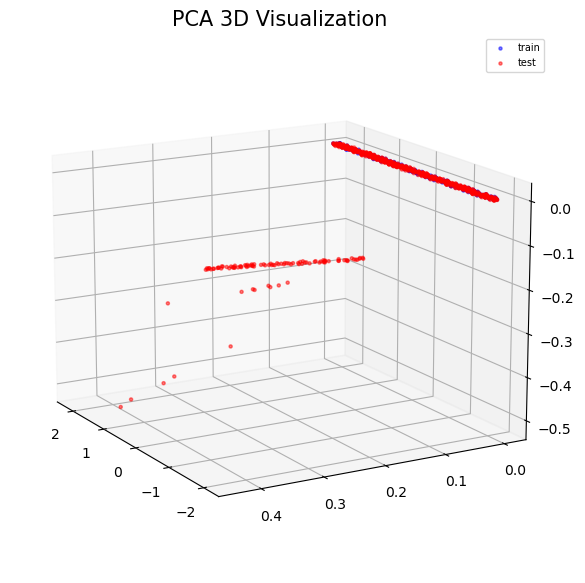

In [6]:
pca = PCA(n_components=3, random_state=1234)
pca3_train = pca.fit_transform(temp_train)
pca3_test = pca.transform(temp_test)

pca3_train = pd.DataFrame(pca3_train, index=temp_train.index, columns=['x','y','z'])
pca3_test = pd.DataFrame(pca3_test, index=temp_test.index, columns=['x','y','z'])

# 3차원 시각화
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca3_train['x'], pca3_train['y'], pca3_train['z'], s=5, color='b', alpha=0.5, label='train')
ax.scatter(pca3_test['x'], pca3_test['y'], pca3_test['z'], s=5, color='r', alpha=0.5, label='test')
    
ax.view_init(elev=15., azim=150)
ax.legend(fontsize=7)
plt.title("PCA 3D Visualization", fontsize=15)
plt.show()

In [7]:
input_train = scaled_train
input_test = scaled_test

In [10]:
from sklearn.ensemble import IsolationForest

submission = pd.DataFrame()
for tp in np.arange(0,8):
    baseline = IsolationForest(max_samples=150, contamination=0.01, random_state=1234)
    temp_train = input_train[input_train.type == tp]
    temp_test = input_test[input_test.type == tp]
    baseline.fit(temp_train)
    temp_pred = pd.DataFrame(baseline.predict(temp_test), index=temp_test.index, columns=["label"])
    temp_pred["type"] = tp
    temp_pred = temp_pred[["type", "label"]]
    submission = pd.concat([submission, temp_pred])

submission[submission.label == 1] = 0
submission[submission.label == -1] = 1

submission.value_counts()

/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  

type  label
0     0        7309
1     1          80
dtype: int64

In [9]:
submission.value_counts()

type  label
0     0        7225
1     1         164
dtype: int64

In [14]:
submission.to_csv("./submission/scaling_if.csv")